In [413]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [414]:
#read our dataframe
preprocessed = pd.read_csv('./Data & Figures/preprocessed.csv', index_col = 0)
preprocessed.head()

,price,bedrooms,bathrooms,grade,sqft_above,sqft_basement,sqft_living15,zip_A,zip_B,zip_C,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,water_1.0,cond_2.0,cond_3.0,cond_4.0,cond_5.0
15937,268950.0,3,1.00,6,880,440.0,1000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20963,399900.0,2,1.75,9,900,510.0,1440,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7614,339000.0,3,1.00,7,720,380.0,1510,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3257,380000.0,2,1.00,7,840,200.0,1930,1,0,0,...,0,0,0,0,0,0,0,0,0,1
16723,365000.0,5,2.00,7,1600,0.0,1190,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [415]:
preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'water_1.0', 'cond_2.0',
       'cond_3.0', 'cond_4.0', 'cond_5.0'],
      dtype='object')

In [416]:
preprocessed.shape

(21229, 26)

# FITTING AN INITIAL MODEL: 
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

We checked for linearity in the first part of the project. Now we are checking out the next two assumptions — normality and homoscedasticity. This requires us to first create a regression model because they refer to a model’s residuals rather than its features. 

This part of the project includes:

1. Fitting an initial regression model, and then conducting statistical analyses of the results. We'll take a look at the p-values of the various features and perform some feature selection. We'll test for regression assumptions including normality, heteroscedasticity, and independence. 
2. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.

In [417]:
features = ['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'water_1.0', 'cond_2.0',
       'cond_3.0', 'cond_4.0', 'cond_5.0']

### Perform Stepwise Selection

In [418]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05.
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [419]:
#apply function
X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_A                          with p-value 0.0


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_C                          with p-value 0.0
Add  sqft_above                     with p-value 0.0


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_basement                  with p-value 0.0
Add  zip_B                          with p-value 9.63715e-226


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living15                  with p-value 3.08946e-101
Add  cond_3.0                       with p-value 5.59705e-86


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_G                          with p-value 2.127e-87
Add  bedrooms                       with p-value 1.58466e-52


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  floors_2.0                     with p-value 5.64044e-44
Add  zip_F                          with p-value 2.23811e-42


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  cond_5.0                       with p-value 4.13846e-22
Add  zip_E                          with p-value 5.16605e-19


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_I                          with p-value 6.27568e-23
Add  floors_1.5                     with p-value 1.87637e-14


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  floors_2.5                     with p-value 4.15382e-13
Add  floors_3.0                     with p-value 8.47335e-08


<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-418-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bathrooms                      with p-value 0.00991749
resulting features:
['grade', 'water_1.0', 'zip_A', 'zip_C', 'sqft_above', 'sqft_basement', 'zip_B', 'sqft_living15', 'cond_3.0', 'zip_G', 'bedrooms', 'floors_2.0', 'zip_F', 'cond_5.0', 'zip_E', 'zip_I', 'floors_1.5', 'floors_2.5', 'floors_3.0', 'bathrooms']


Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

The null hypothesis for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject the null hypothesis. All of the p-values indicate that all of the current features are substantially influential.

In [420]:
#build initial model again in statsmodels
import statsmodels.api as sm

X_fin = X[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     2398.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:21:24   Log-Likelihood:            -2.8740e+05
No. Observations:               21229   AIC:                         5.748e+05
Df Residuals:                   21208   BIC:                         5.750e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.16e+05   1.23e+04    -50.000      0.000    -6.4e+05   -5.92e+05
grade          8.491e+04   1968.837     43.127      0.000    8.11e+04    8.88e+04
water_1.0      7.334e+05   1.62e+04     45.161      0.000    7.02e+05    7.65e+05
zip_A          2.689e+05   4234.702     63.490      0.000    2.61e+05    2.77e+05
zip_C          2.533e+05   5113.818     49.530      0.000    2.43e+05    2.63e+05
sqft_above      164.2420      3.532     46.497      0.000     157.318     171.166
sqft_basement   144.0475      4.100     35.132      0.000     136.011     152.084
zip_B          1.633e+05   4843.803     33.718      0.000    1.54e+05    1.73e+05
sqft_living15    60.8468      3.240     18.778      0.000      54.496      67.198
cond_3.0      -4.173e+04   3082.338    -13.537      0.000   -4.78e+04   -3.57e+04
zip_G          1.123e+05   5590.476     20.091      0.000    1.01e+05    1.23e+05
bedrooms      -2.836e+04   1853.742    -15.300      0.000    -3.2e+04   -2.47e+04
floors_2.0    -4.426e+04   4008.097    -11.042      0.000   -5.21e+04   -3.64e+04
zip_F         -4.232e+04   5593.152     -7.566      0.000   -5.33e+04   -3.14e+04
cond_5.0        4.75e+04   5144.307      9.233      0.000    3.74e+04    5.76e+04
zip_E          6.517e+04   6058.690     10.757      0.000    5.33e+04     7.7e+04
zip_I          8.192e+04   8297.296      9.873      0.000    6.57e+04    9.82e+04
floors_1.5     3.623e+04   4896.180      7.399      0.000    2.66e+04    4.58e+04
floors_2.5     1.004e+05   1.54e+04      6.518      0.000    7.02e+04    1.31e+05
floors_3.0    -5.052e+04   8645.586     -5.844      0.000   -6.75e+04   -3.36e+04
bathrooms      7697.6928   2984.845      2.579      0.010    1847.170    1.35e+04
==============================================================================
Omnibus:                    13158.231   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           315866.326
Skew:                           2.566   Prob(JB):                         0.00
Kurtosis:                      21.187   Cond. No.                     3.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [421]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 26)

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [422]:
#fit the linear regression model again using the 5 selected columns
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression()

In [423]:
#predict yhat using our model
yhat = linreg.predict(X[selected_columns])
yhat

array([108455.21465871, 519865.53750593, 435128.28708931, ...,
       301557.27449278, 506801.63546835, 222591.21001785])

In [424]:
#compute r-squared and contrast them with the r-squared (0.693) and adjusted r-squared (0.693) in our statsmodels output using stepwise selection
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

print('r_squared:', r_squared)
print('adjusted_r_squared:', adjusted_r_squared)

r_squared: 0.6934877399041717
adjusted_r_squared: 0.693126337909058


Our r_squared and adjusted_r_squared are very very similar in both cases: 69% of the dataset's variation from the mean can be explained by our model.

In [425]:
#get intercept
linreg.intercept_

-547812.5802785079

In [426]:
#get coefficient
coefficients = dict(zip(X,list(linreg.coef_)))
coefficients

{'bedrooms': -28507.01119088774,
 'bathrooms': 7582.770208825827,
 'grade': 84581.02485830462,
 'sqft_above': 164.33682399164138,
 'sqft_basement': 143.95480155666343,
 'sqft_living15': 61.236631796438175,
 'zip_A': 168629.7923967015,
 'zip_B': 63081.859568498105,
 'zip_C': 153014.41210854333,
 'zip_D': -96132.65002956825,
 'zip_E': -34758.21225423717,
 'zip_F': -142547.4963168512,
 'zip_G': 12033.749337004632,
 'zip_H': -104974.45277283799,
 'zip_I': -18347.002037252776,
 'floors_1.5': 36373.507254321725,
 'floors_2.0': -43662.9417681264,
 'floors_2.5': 101069.76605438128,
 'floors_3.0': -49922.925421208114,
 'floors_3.5': 127791.20408376199,
 'water_1.0': 733250.1479654075,
 'cond_2.0': 19659.131023755144,
 'cond_3.0': -7715.028188547507,
 'cond_4.0': 34689.512448685586,
 'cond_5.0': 81727.63482463754}

**Features that add values:**
bedrooms, bathrooms, grade, sqft_above, sqft_basement, floors 1-2

**Features that lower values:**
sqft_living15, floors 2.5-3.5

In [427]:
['{} Bedrooms: +${}'.format(i, round(coefficients['bedrooms'] * np.log(i), 0))
 for i in range(1, 6)]

['1 Bedrooms: +$-0.0',
 '2 Bedrooms: +$-19760.0',
 '3 Bedrooms: +$-31318.0',
 '4 Bedrooms: +$-39519.0',
 '5 Bedrooms: +$-45880.0']

In [428]:
['{} Bathrooms: +${}'.format(i, round(coefficients['bathrooms'] * np.log(i), 0))
 for i in range(1, 6)]

['1 Bathrooms: +$0.0',
 '2 Bathrooms: +$5256.0',
 '3 Bathrooms: +$8331.0',
 '4 Bathrooms: +$10512.0',
 '5 Bathrooms: +$12204.0']

In [429]:
['Grade {}: +${}'.format(i, round(coefficients['grade'] * np.log(i), 0))
 for i in range(1, 6)]

['Grade 1: +$0.0',
 'Grade 2: +$58627.0',
 'Grade 3: +$92922.0',
 'Grade 4: +$117254.0',
 'Grade 5: +$136128.0']

In [430]:
['Square Footage Above {}: +${}'.format(i, round(coefficients['sqft_above'] * np.log(i), 0))
 for i in range(1, 6)]

['Square Footage Above 1: +$0.0',
 'Square Footage Above 2: +$114.0',
 'Square Footage Above 3: +$181.0',
 'Square Footage Above 4: +$228.0',
 'Square Footage Above 5: +$264.0']

In [431]:
['Square Footage Basement {}: +${}'.format(i, round(coefficients['sqft_basement'] * np.log(i), 0))
 for i in range(1, 6)]

['Square Footage Basement 1: +$0.0',
 'Square Footage Basement 2: +$100.0',
 'Square Footage Basement 3: +$158.0',
 'Square Footage Basement 4: +$200.0',
 'Square Footage Basement 5: +$232.0']

In [432]:
['Floors {}: +${}'.format(i, round(coefficients['floors_1.5'] * np.log(i), 0))
 for i in range(1, 6)]

['Floors 1: +$0.0',
 'Floors 2: +$25212.0',
 'Floors 3: +$39960.0',
 'Floors 4: +$50424.0',
 'Floors 5: +$58541.0']

## Test Initial Model

In [433]:
#fit the linear regression model again using the selected columns
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression()

In [434]:
#predict yhat using our model
yhat = linreg.predict(X[selected_columns])

In [435]:
#check out selected columns/ features
X[selected_columns]

,bedrooms,bathrooms,grade,sqft_above,sqft_basement,sqft_living15,zip_A,zip_B,zip_C,zip_D,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,water_1.0,cond_2.0,cond_3.0,cond_4.0,cond_5.0
15937,3,1.00,6,880,440.0,1000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20963,2,1.75,9,900,510.0,1440,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7614,3,1.00,7,720,380.0,1510,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3257,2,1.00,7,840,200.0,1930,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16723,5,2.00,7,1600,0.0,1190,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,4,2.00,7,760,890.0,1480,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8800,3,1.00,6,1010,420.0,1290,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8404,3,1.00,7,1460,0.0,2250,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6729,4,1.75,8,1160,900.0,2590,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


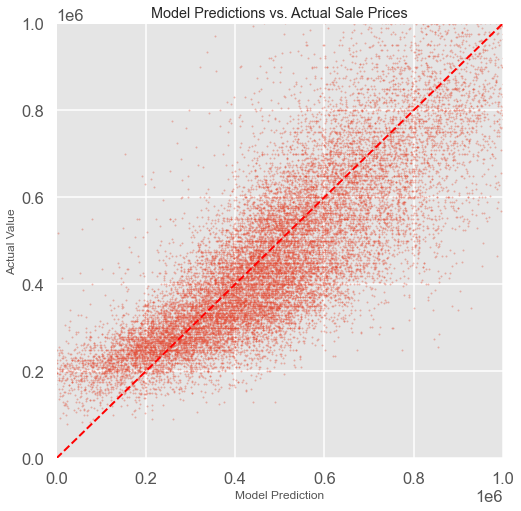

In [436]:
plt.figure(figsize = (8,8))
plt.scatter(yhat, y, s = 2, alpha = 0.3)
plt.plot([0,1000000], [0,1000000], color = 'red', ls = '--')

plt.xlim(0,1000000)
plt.ylim(0,1000000)

#set label
plt.title('Model Predictions vs. Actual Sale Prices')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');

## Validate Initial Model

In order to get a good sense of how well your model will be doing on new instances, you'll have to perform a so-called "train-test-split". What you'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [437]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(y_train), len(X_test), len(y_test))

15921 15921 5308 5308


In [438]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

In [439]:
#fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression()

In [440]:
#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [441]:
#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [442]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

32498359292.182587
37121489359.416664


## Additional Assessments

In [443]:
#recheck for multicollinearity
X = preprocessed[features]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(features, vif))

[('price', 3.2625122391103014),
 ('bedrooms', 1.7265415054894477),
 ('bathrooms', 2.952177786629134),
 ('grade', 3.4980081994119114),
 ('sqft_above', 5.433759896798901),
 ('sqft_basement', 2.108224764167214),
 ('sqft_living15', 3.0569746987343036),
 ('zip_A', 286.6713742476927),
 ('zip_B', 113.65660568039257),
 ('zip_C', 101.23114387498286),
 ('zip_D', 64.4977697689659),
 ('zip_E', 54.46971470964181),
 ('zip_F', 67.03965703523183),
 ('zip_G', 72.89416563345372),
 ('zip_H', 58.52530411209096),
 ('zip_I', 24.182019763513853),
 ('floors_1.5', 1.2266043423179693),
 ('floors_2.0', 2.4085256589342077),
 ('floors_2.5', 1.0743655042782734),
 ('floors_3.0', 1.2966240767102215),
 ('floors_3.5', 1.0048995080297916),
 ('water_1.0', 1.1275094153915128),
 ('cond_2.0', 6.750433403751268),
 ('cond_3.0', 174.66260282631765),
 ('cond_4.0', 149.16036493886432),
 ('cond_5.0', 56.43323357894351)]

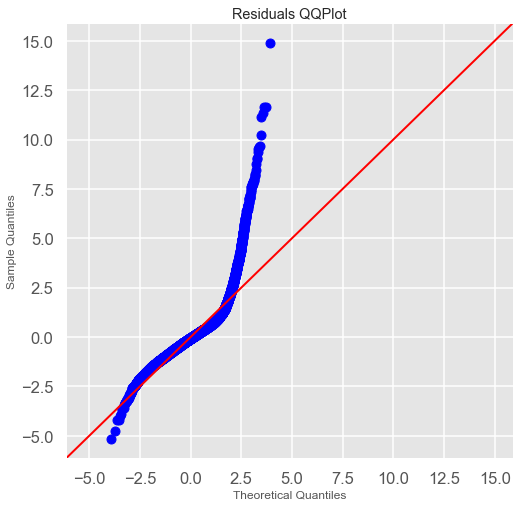

In [444]:
#check for normality
fig = sm.graphics.qqplot(model.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(8, 8)

#set labels
plt.title('Residuals QQPlot')

#show
plt.show()

Since majority of our data points did not fall along a straight line in this QQ-plot, we failed the normality assumption.

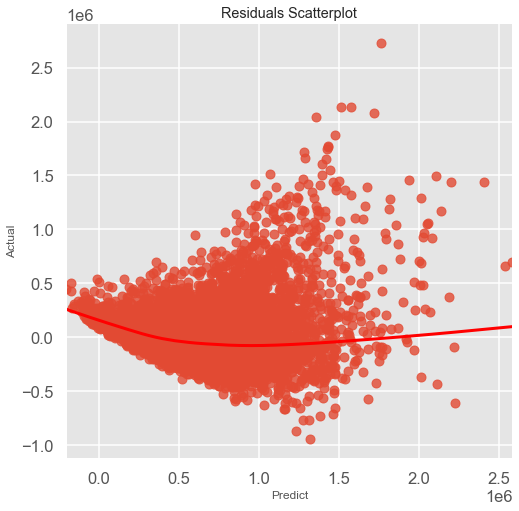

In [445]:
#check for homoscedasticity
plt.figure(figsize = (8, 8))
sns.regplot(x = model.predict(), 
            y = model.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})

#set labels
plt.title('Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')

#show
plt.show()

We can see that the points do not have a roughly symmetrical blob-like shape that is consistent across the x-axis. We failed homoscedascity test.

## K-Fold Cross Validation

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [449]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([9.64820352e-21, 3.87123952e-20, 9.35722279e-21, 6.33899528e-20,
       6.28249320e-21, 1.23876077e-20, 1.19506384e-20, 6.76913854e-20,
       6.02439727e-21, 2.23322728e-20, 7.83057047e-21, 7.34477216e-21,
       1.43582050e-20, 3.04578100e-20, 2.56053077e-21, 5.94338106e-20,
       6.64372783e-21, 3.47393124e-20, 2.67941434e-20, 5.88319190e-20,
       9.86992685e-21, 3.64946637e-20, 1.19424670e-19, 4.83904940e-21,
       8.89484246e-21, 1.06486989e-20, 5.84153781e-21, 9.79369389e-21,
       9.26753695e-21, 5.30654155e-20, 1.18664521e-20, 4.19620921e-21,
       8.75400560e-21, 2.04466562e-21, 1.37148418e-20, 1.73821549e-20,
       9.76684924e-21, 6.37257447e-20, 8.13920751e-21, 3.61052788e-20,
       5.88098571e-20, 1.37547962e-20, 1.54363764e-20, 1.17356015e-20,
       8.88235906e-21, 9.51094141e-20, 1.32698499e-20, 6.20991018e-21,
       5.37646172e-20, 6.44414276e-21])

In [450]:
cv_result.mean()

2.4480474803311577e-20

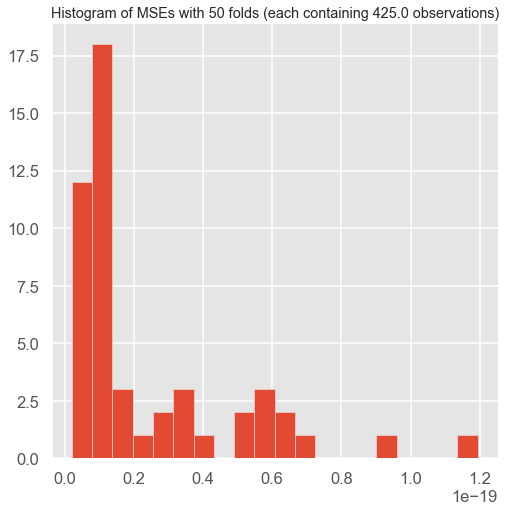

In [455]:
#visualize the cv_result

folds = 50
plt.figure(figsize = (8, 8))
plt.hist(cv_result, bins = 20);

#set labels
plt.title('Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed) / folds, 0)));

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [399]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [400]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [401]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [402]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -973489.6171467217 
Train variance: 20041877463.03827


In [403]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -968348.4822701213 
Test variance: 19259443155.20349


## MODEL REFINEMENT I: 
## INTERACTIONS

**Comment:** While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables. With that, it makes sense to briefly update the features once again and recheck for multicollinearity.

In [408]:
regression = LinearRegression()

In [409]:
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

In [410]:
baseline = np.mean(cross_val_score(regression, X, y, scoring = 'r2', cv = crossvalidation))
baseline

1.0

### See how interactions improve our baseline

Create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the  𝑅2 . We'll look at the 3 interactions which have the biggest effect on our  𝑅2 , so print out the top 3 combinations.

In [411]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
100
150
200
250
300
Top 3 interactions: []


Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against SalePrice. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [ ]:
#fig, ax = plt.subplots(figsize=(13, 10))

col = 'LotArea'

is_in = preprocessed.loc[preprocessed['Neighborhood_Edwards'] == 1, [col, 'SalePrice']]

linreg = LinearRegression()
linreg.fit(np.log(is_in[[col]]), np.log(is_in['SalePrice']))

preds = linreg.predict(np.log(is_in[[col]]))

ax.scatter(np.log(is_in[[col]]), np.log(is_in['SalePrice']), alpha=.3, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'In Edwards:   {linreg.coef_[0]:.2f}')

not_in = preprocessed.loc[preprocessed['Neighborhood_Edwards'] == 0, [col, 'SalePrice']]

linreg = LinearRegression()
linreg.fit(np.log(not_in[[col]]), np.log(not_in['SalePrice']))

preds = linreg.predict(np.log(not_in[[col]]))

ax.scatter(np.log(not_in[[col]]), np.log(not_in['SalePrice']), alpha=.1, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'Outside of Edwards:   {linreg.coef_[0]:.2f}')

ax.legend()

In [ ]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['Neighborhood_Edwards*LotArea'] = final['Neighborhood_Edwards'] * final['LotArea']

final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

final_model

In [ ]:
#r2has increased considerably! Let's have a look in statsmodels to see if this interactions are significant.
import statsmodels.api as sm

df_inter_sm = sm.add_constant(final)
model = sm.OLS(y, final)
results = model.fit()

results.summary()

## MODEL REFINEMENT II